# Traveling Salesman Problem
The Traveling Salesman Problem (TSP) concerns finding the shortest path that a traveling salesman can take to go through a list of cities in the shortest time possible. This problem is represented in a graph $G =(V,E)$. Each vertex in the graph $G$ represents a different camp, while the weights on each of the edges $(u,v)$ represent the distance between the two camps $u$ and $v$. 

This is an NP-Hard problem, and there is no known classical algorithm that is know to solve this problem in linear time. 


# Real Life Challenges 

In this challenge, you will be tasked with solving TSP for an extended graph on a quantum computer that has a limited number of qubits. Specifically, the quantum computer will only have 6 qubits available. Moreover, the extended graph includes two new nodes a starting and ending locations. Your solution must begin at the starting point which is Karanga Camp and end at the Kibo peak.

To solve this challenge, you will need to accomplish the following tasks:

1. Design and build a new Hamiltonian that takes into account the lack of qubits and the addition of the two new nodes.
2. Calculate and analyze the fidelity of both the AQO and QAOA solutions.
3. Experiment with different scheduling strategies to improve the fidelity of your solution.

It is important that you document the steps you follow and your findings in a clear and concise manner. Good luck!

## Graph construction 

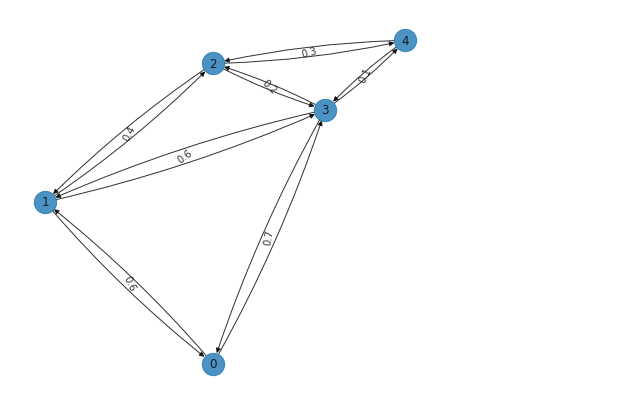

In [1]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.6)
G.add_edge(1, 0, weight=0.6)

G.add_edge(0, 3, weight=0.7)
G.add_edge(3, 0, weight=0.7)

G.add_edge(1, 3, weight=0.6)
G.add_edge(3, 1, weight=0.6)

G.add_edge(1, 2, weight=0.4)
G.add_edge(2, 1, weight=0.4)

G.add_edge(2, 3, weight=0.2)
G.add_edge(3, 2, weight=0.2)

G.add_edge(3, 4, weight=0.1)
G.add_edge(4, 3, weight=0.1)

G.add_edge(2, 4, weight=0.3)
G.add_edge(4, 2, weight=0.3)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500, connectionstyle='arc3, rad = 0.05')

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()


## Solution 

Running adiabatic optimization using the cost hamiltonian succeeded.

QAOA on the other hand, does not work as fine. Dumb QAOA does not work as fine (althogh we get nonzero counts for Since constraints are not built in we tried to increase weights of hard contraints (with respect to optimization part). This actually had the effect of reducing the occurence of unfeasible solutions.

In [2]:
from qibo.symbols import Z, X, Y
from qibo import hamiltonians

def edge_distance(node1: int, node2: int, G: nx.Graph):
    if (node1, node2) in G.edges():
        return edge_labels[(node1, node2)]
    else:
        return 2

def calculate_weight(alpha: int, beta: int, G: nx.Graph):
    first_weight = edge_distance(0, alpha + 1, G)
    second_weight = edge_distance(alpha + 1, beta + 1, G)
    third_node = {1, 2, 3} - {alpha + 1} - {beta + 1}
    third_weight = edge_distance(beta + 1, list(third_node)[0], G)
    fourth_weight = edge_distance(list(third_node)[0], 4, G)
    return first_weight + second_weight + third_weight + fourth_weight

def build_TSP_hamiltonian(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the cost hamiltonian.

    args: 
        G: a networkx graph
            the graph representing the camp distribution. 
            
    
    returns:
        The symbolic cost hamiltonian of the TSP with respect to the nodes specified in the graph
    '''
    n = G.number_of_nodes()
    n_eff = n-2
    
    h1 = 0
    for j in range(n_eff-1):
        term = 1
        for alpha in range(n_eff):
            term -= (1 - Z(alpha + j*n_eff))/2
        h1 += term ** 2
    h1 -= 1
    
    h2 = 0
    for alpha in range(n_eff):
        term = 1
        for j in range(n_eff-1):
            term -= (1 - Z(alpha + j*n_eff))/2
        h2 += term ** 2
    
    h3 = 0
    for alpha in range(n_eff):
        for beta in range(n_eff):
            if (alpha+1, beta+1) not in G.edges():
                h3 += (1-Z(alpha))/2 * (1-Z(beta + n_eff))/2
                    
    # minimizer hamiltonian
    h4 = 0
    for alpha in range(n_eff):
        for beta in range(n_eff):
            h4 += calculate_weight(alpha, beta, G) * (1-Z(alpha)) / 2 * (1-Z(beta + n_eff)) / 2
    
    return hamiltonians.SymbolicHamiltonian(5*h1 + 5*h2 + h3 + h4)

def S_plus(i):
    return X(i) + Y(i)

def S_minus(i):
    return X(i) - Y(i)

def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the quantum alternating operator ansatz (QAOA).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The symbolic mixer hamiltonian of the TSP with respect to the nodes specified in the graph

    '''
    n_eff = G.number_of_nodes() - 2
    sham = 0
    for (u,v) in G.edges():
        if u in {1, 2, 3} and v in {1, 2, 3}:
            u_i = u-1
            v_i = v-1

            u_i_plus = u_i + n_eff
            v_i_plus = v_i + n_eff
            
            sham += S_plus(u_i)*S_plus(v_i_plus)*S_minus(u_i_plus)*S_minus(v_i) + \
                    S_minus(u_i)*S_minus(v_i_plus)*S_plus(u_i_plus)*S_plus(v_i)
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the initial hamiltonian for the adiabatic quantum optimization (AQO).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        A symbolic hamiltonian representing the initial hamiltonian that will be used in the adiabatic optimization. 

    '''
    n_eff = G.number_of_nodes() - 2
    sham = sum((X(i)) for i in range(n_eff*(n_eff-1))) 
    
    return hamiltonians.SymbolicHamiltonian(sham)

def prepare_initial_state(bitstring: str):
    '''
    prepare the initial state of the system.

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The initial state of the system.

    '''
    state = np.array([1,0]) if bitstring[0] == "0" else np.array([0, 1])
    for bit in bitstring[1:]:
        if bit == "0":
            state = np.kron(state, np.array([1,0]))
        else:
            state = np.kron(state, np.array([0,1]))
    return state

def display_solution(state: str, G: nx.Graph):
    '''
    display the solution of the TSP.

    args:
        state: string 
            A string encoding the TSP solution
    '''
    n = 3
    node_list = [0]
    edge_list = list()
    
    # populate node list
    for i in range(n-1):
        column = state[i*n:(i+1)*n]
        one_loc = 0
        for i in range(n):
            if column[i] == "1":
                one_loc = i+1
                break
        node_list.append(one_loc)
    node_list += list({0, 1, 2, 3} - set(node_list))
    node_list.append(4)
    
    # create edge list from node list
    for i in range(4):
        edge_list.append((node_list[i], node_list[i+1]))
        
    ##### copy drawing stuff from above #####
    # save the labels of the various edges to be able to plot them.
    edge_labels= {}
    for (u,v) in G.edges():
        edge_labels[(u,v)] = G[u][v]["weight"]

    pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}

    # applying a shift to the node labels for readability purposes 
    shift = np.array([0.03, 0])
    shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

    #plot the graph and the edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
    nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500, connectionstyle='arc3, rad = 0.05')
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color = "r", connectionstyle='arc3, rad = 0.05')

    # adjust frame to avoid cutting text, may need to adjust the value
    axis = plt.gca()
    lim = axis.get_xlim()
    axis.set_xlim([lim[0], lim[1] * 1.7])

    # increase the size of the figure
    figure_size = plt.gcf().get_size_inches()
    factor = 1.8
    plt.gcf().set_size_inches(factor * figure_size)

    plt.show()

# Adiabatic

In [3]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian

# build initial (H0) and target (H1) hamiltonians
H1 = build_TSP_hamiltonian(G)
H0 = build_initial_hamiltonian(G)

dt = 0.1
n_eff = G.number_of_nodes() - 2

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(n_eff * (n_eff - 1), H1.matrix)
H0_dense = Hamiltonian(n_eff * (n_eff - 1), H0.matrix)

# define the scheduler
def s(t): return t



# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

[Qibo 0.1.13|INFO|2023-05-07 11:19:09]: Using numpy backend on /CPU:0
[Qibo 0.1.13|WARNING|2023-05-07 11:19:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.13|WARNING|2023-05-07 11:19:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [4]:
eigval, _ = np.linalg.eig(H1.matrix)
print(np.sort(eigval)[:10])

[1.3+0.j 1.7+0.j 2. +0.j 3. +0.j 3.1+0.j 3.3+0.j 4.6+0.j 4.8+0.j 5.1+0.j
 5.3+0.j]


100010


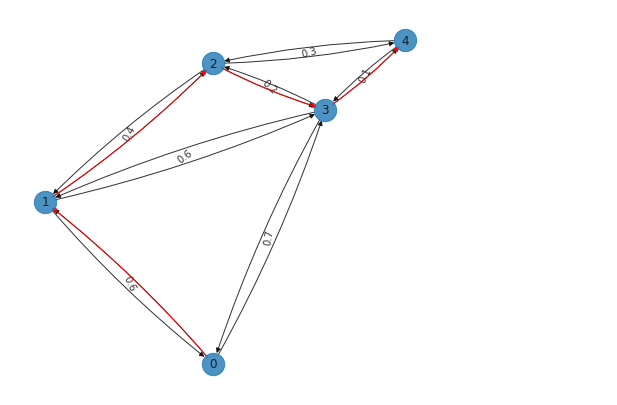

In [5]:
# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=10) 

# obtain the state with the highest probability
solution_dec = (np.abs(adiabatic_quantum_state) ** 2).argmax()

adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=6)
print(adiabatic_solution)
display_solution(adiabatic_solution, G)

Text(0, 0.5, 'probability')

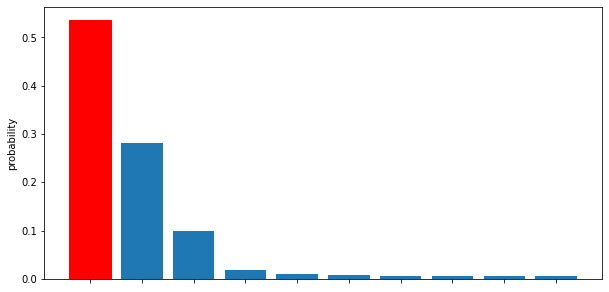

In [6]:
import matplotlib.pyplot as plt

# plotting 10 states with highest count for visibility

problist = np.abs(adiabatic_quantum_state) ** 2
problist[::-1].sort()
plt.figure(figsize=(10,5))
barlist = plt.bar(list(range(10)), problist[:10], tick_label = [None for i in range(10)])
barlist[0].set_color('r')
plt.ylabel("probability")

In [7]:
print("Fidelity =", problist[0])

Fidelity = 0.5363262064790572
